# Analysis of Monthly Mean Hydrologic Future Variables from LOCA and BCSD

This notebook analyzes hydrologic variables from the historical (1950-2005) and RCP (2006-2100) scenarios from the LOCA and BCSD datasets. 

Variables include:
- Total Runoff
- ET
- SWE

In [11]:
from loca import print_date
print_date()

Last executed: 2019-08-09 14:54:05.269864 by jvano on casper05


# Imports and Options

In [12]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import xarray as xr

from loca.data_catalog import load_monthly_cmip_hydro_datasets, resample_monthly_data
from loca.utils import calc_change

# models currently using:
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1'] 

# list of 23:
# models = ['ACCESS1-0', 'CanESM2', 'MIROC5', 'MRI-CGCM3', 'bcc-csm1-1', 'bcc-csm1-1-m',
#           'CESM1-BGC', 'CMCC-CM', 'HadGEM2-CC', 'HadGEM2-ES', 'inmcm4', 'IPSL-CM5A-MR',
#           'MIROC-ESM', 'MIROC-ESM-CHEM', 'MPI-ESM-LR', 'MPI-ESM-MR', 'NorESM1-M', 'GFDL-ESM2G', 
#           'CNRM-CM5', 'CSIRO-Mk3-6-0', 'GFDL-ESM2M','GFDL-CM3', 'HadGEM2-AO']

models = ['ACCESS1-0', 'CanESM2']

#cache is written in script "write_cache.ipynb"  TODO
read_cache = True
# cache_dir = os.environ['TMPDIR']
cache_dir = '/glade/u/home/jvano/scratch/'

hydro_vars = ['ET', 'total_runoff', 'SWE']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
from dask.distributed import Client
client = Client(scheduler_file=os.path.join(os.environ['HOME'], 'scheduler_file.json'))
client

Client Scheduler: tcp://128.117.181.211:39229 Dashboard: proxy/8787/status,Cluster Workers: 2 Cores: 4 Memory: 30.00 GB


# Load Data

In [14]:
write_cache = False  

if write_cache:
    xr.set_options(file_cache_maxsize=12000)
    hist_data = load_monthly_cmip_hydro_datasets('historical', models=models, autoclose=False, parallel=True)
    rcp4_data = load_monthly_cmip_hydro_datasets('rcp45', models=models, autoclose=False, parallel=True)
    rcp8_data = load_monthly_cmip_hydro_datasets('rcp85', models=models, autoclose=False, parallel=True)

In [15]:
if write_cache:
    for key, ds in hist_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_hist.{key}_{gcm}.nc'))
    for key, ds in rcp4_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp4.{key}_{gcm}.nc'))
    for key, ds in rcp8_data.items():
        for gcm in models:
            ds.sel(gcm=gcm).load().to_netcdf(os.path.join(os.environ['TMPDIR'], f'monthly_cmip_hydro_rcp8.{key}_{gcm}.nc'))

In [16]:
read_cache = True
hist_data = {}
rcp4_data = {}
rcp8_data = {}
if read_cache:
    for key in ['loca', 'bcsd']:
        hist_data[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_hydro_hist.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp4_data[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_hydro_rcp4.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})
        rcp8_data[key] = xr.open_mfdataset(
            os.path.join(cache_dir, f'monthly_cmip_hydro_rcp8.{key}_*.nc'),
            concat_dim='gcm', chunks={'time': 72})

In [17]:
hist_epoch = slice('1970-01-01', '1999-12-31')
futr_epoch = slice('2070-01-01', '2099-12-31')

mask = hist_data['bcsd']['total_runoff'].isel(gcm=0, time=0).squeeze().notnull()

hist_means = dict((k, resample_monthly_data(ds.sel(time=hist_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in hist_data.items())
rpc4_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp4_data.items())
rpc8_means = dict((k, resample_monthly_data(ds.sel(time=futr_epoch), freq='AS').persist().mean('time').where(mask).persist())
                  for (k, ds) in rcp8_data.items())

# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations 

In [18]:
# kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
#           'total_runoff': {'vmin': 0, 'vmax': 800},}

kwargs = {'ET': {'vmin': 0, 'vmax': 1000},
          'total_runoff': {'vmin': 0, 'vmax': 1000}, 'SWE': {'vmin': 0, 'vmax': 100},}
units = {'ET': 'mm', 'total_runoff': 'mm', 'SWE': 'mm'}

subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)]

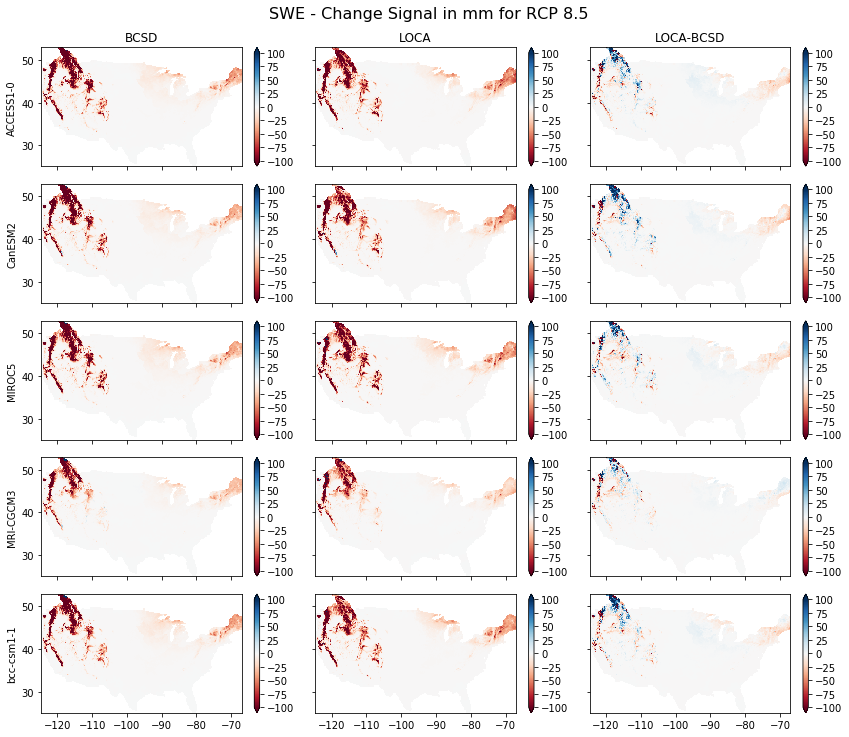

In [19]:
# USE FOR PLOT IN APPENDIX

# Plot of change signal with BCSD, LOCA, and LOCA-BCSD
models = ['ACCESS1-0', 'CanESM2','MIROC5', 'MRI-CGCM3','bcc-csm1-1'] #current 5
gcmnum = 'gcm5'

# hydro_vars = ['ET', 'total_runoff', 'SWE']
hydro_vars = ['SWE']
# subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)]
subcols = [('RCP 8.5', rpc8_means)]
# subcols = [('RCP 4.5', rpc4_means)]

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

# for pct in [False, True]:
for pct in [False]:
    for var in hydro_vars:
        
        if var not in diff_kws[pct]:
            continue

        fig, axes = plt.subplots(ncols=3, nrows=len(models), sharex=True, sharey=True, figsize=(12, 2*len(models)))

        for row, model in enumerate(models):
            
            for col, (rcp, ds_dict) in enumerate(subcols[0:]):             

                bcsd_diff = calc_change(hist_means['bcsd'][var].sel(gcm=model), ds_dict['bcsd'][var].sel(gcm=model), pct=pct)
                loca_diff = calc_change(hist_means['loca'][var].sel(gcm=model), ds_dict['loca'][var].sel(gcm=model), pct=pct)

                ax = axes[row, 0]
                bcsd_diff.plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                if row == 0:
                    ax.set_title('BCSD')
                ax.set_ylabel(model)
                
                ax = axes[row, 1]
                loca_diff.plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                if row == 0:
                    ax.set_title('LOCA')
#                     ax.set_title(rcp)
                
                ax = axes[row, 2]
                (loca_diff - bcsd_diff).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])
                if row == 0:
                    ax.set_title('LOCA-BCSD')
        
        if pct:
            title = var.upper() + " - difference (%) in Change Signal)"
            unit_str = 'pct'
        else:
            unit_str = 'mm'
            title = var.upper() +  " - Change Signal in mm for %s" %rcp
        fig.suptitle(title, fontsize=16, y=1.02)
        fig.tight_layout() 
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/{gcmnum}_diff2_{var}_{unit_str}_{rcp}_mon_fut_hydro_change.png', dpi=300, bbox_inches='tight')
        

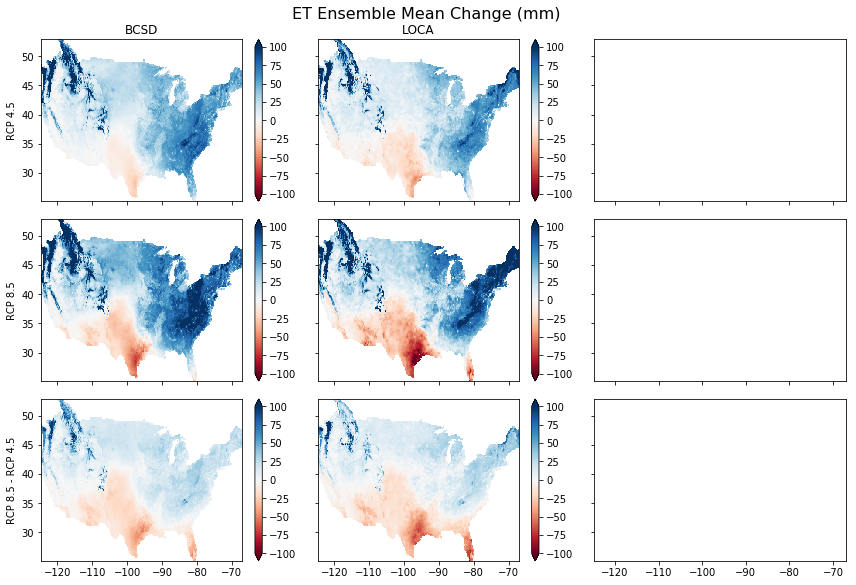

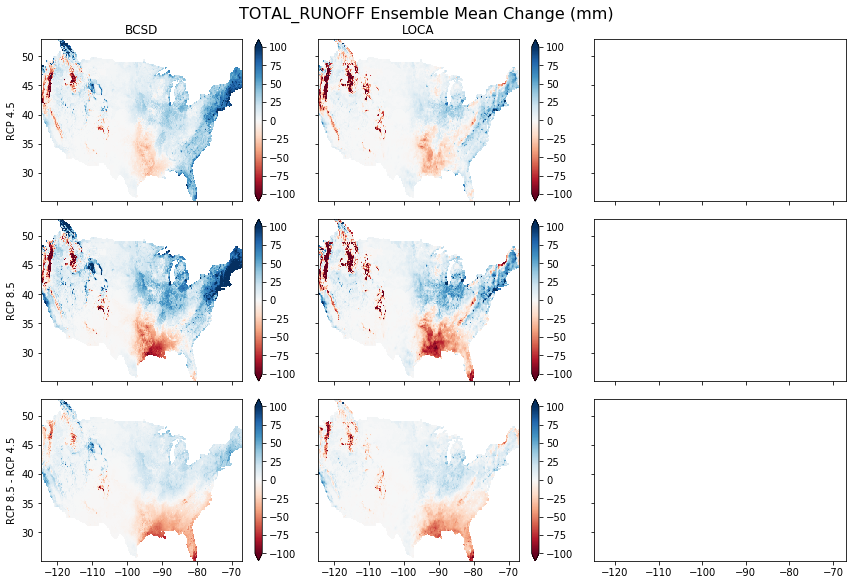

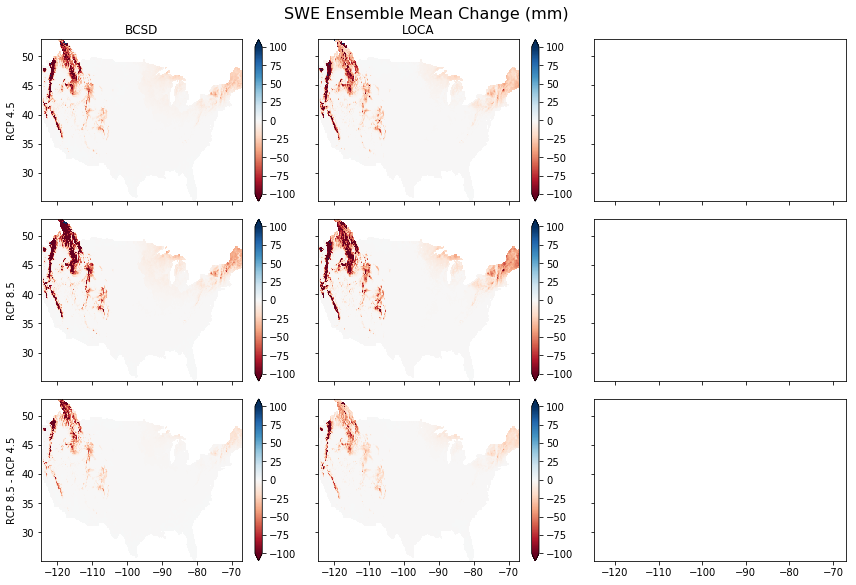

In [20]:
# USE PLOTS M-N

cache = {}

# for testing.  if make all 4.5, diff is zero
subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
hydro_vars = ['ET', 'total_runoff', 'SWE']
# hydro_vars = ['total_runoff']

diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'SWE': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                     'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                     'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

for pct in [False]:

    for var in hydro_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(12, 8))

        for col, dset in enumerate(['bcsd', 'loca']):

            for row, (title, dsets) in enumerate(subcols[1:]):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(dset.upper())
                if col == 0:
                    ax.set_ylabel(title)

            diff = cache[(row, col)] - cache[(row - 1, col)]
            diff.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])
            
#             diff2 = cache[(row, col)] - cache[(row, col - 1)]
#             diff2.plot.pcolormesh(ax=axes[row, col + 1], add_labels=False, **diff2_kws[pct][var])
            
        axes[-1, 0].set_ylabel('RCP 8.5 - RCP 4.5')
   

        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()          
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff4b_{var}_{unit_str}_mon_fut_hydro.png', dpi=300, bbox_inches='tight')
        

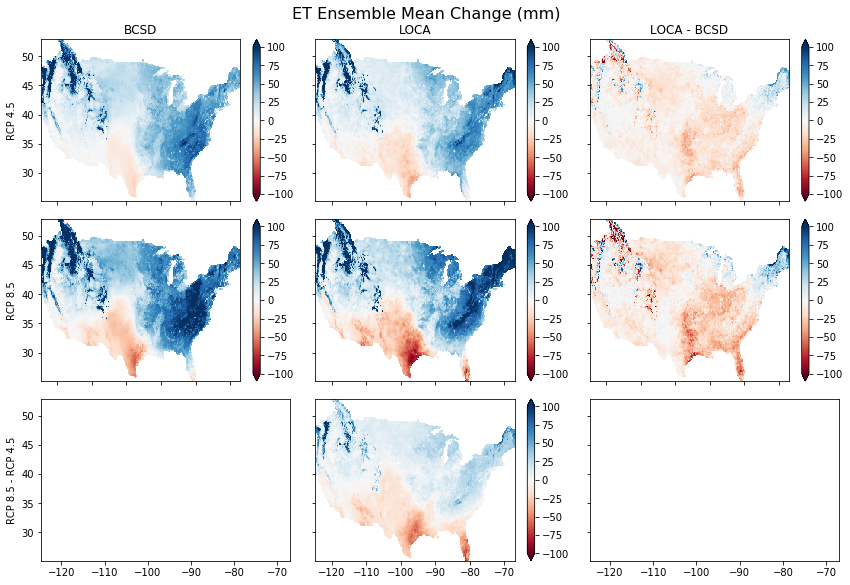

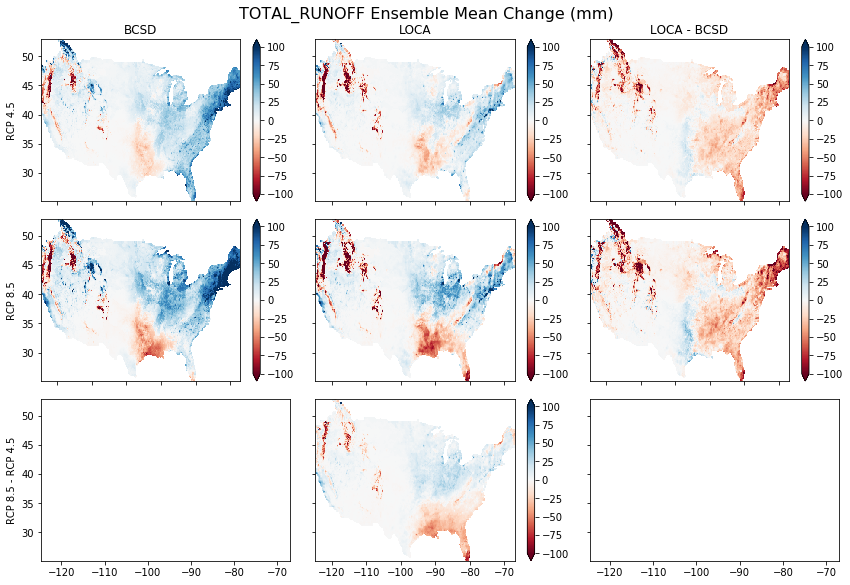

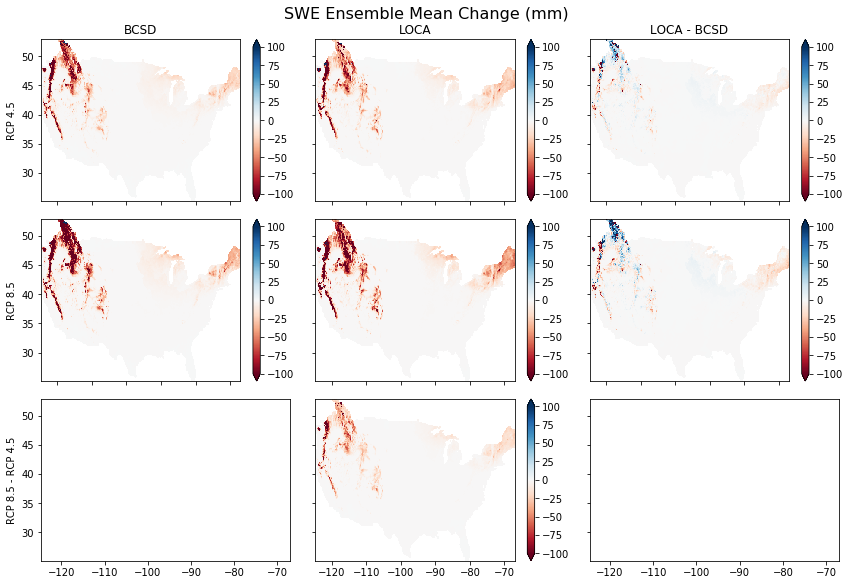

In [15]:
# USE PLOTS M-N

cache = {}

# for testing.  if make all 4.5, diff is zero
subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
hydro_vars = ['ET', 'total_runoff', 'SWE']


diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'SWE': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                     'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                     'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 
for pct in [False]:

    for var in hydro_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(12, 8))

        for row, (title, dsets) in enumerate(subcols[1:]):

            for col, dset in enumerate(['bcsd', 'loca']):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(dset.upper())
                if col == 0:
                    ax.set_ylabel(title)

            diff = cache[(row, col)] - cache[(row, col - 1)]
            diff.plot.pcolormesh(ax=axes[row, col + 1], add_labels=False, **diff2_kws[pct][var])
            axes[0, -1].set_title('LOCA - BCSD')
            
        diff2 = cache[(row, col)] - cache[(row - 1, col)]
        diff2.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])  # only plots second row.  how loop it in?
            
        axes[-1, 0].set_ylabel('RCP 8.5 - RCP 4.5')

    
        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()
        fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff4a_{var}_{unit_str}_mon_fut_hydro.png', dpi=300, bbox_inches='tight')
        
    

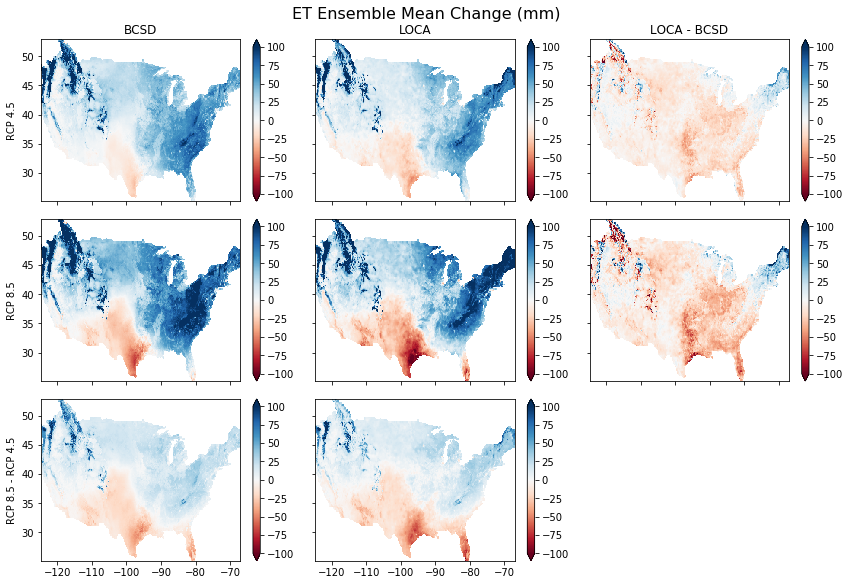

In [24]:
# COMBINED FIG

cache = {}

# for testing.  if make all 4.5, diff is zero
subcols = [('Historical', hist_means), ('RCP 4.5', rpc4_means), ('RCP 8.5', rpc8_means)] 
hydro_vars = ['ET']


diff_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}, 
            False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                   'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 

diff2_kws = {True: {'ET': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'total_runoff': {'vmin': -25, 'vmax': 25, 'cmap': 'RdBu', 'extend': 'both'},
                    'SWE': {'vmin': -50, 'vmax': 50, 'cmap': 'RdBu', 'extend': 'both'}}, 
             False: {'ET': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                     'total_runoff': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'},
                     'SWE': {'vmin': -100, 'vmax': 100, 'cmap': 'RdBu', 'extend': 'both'}}} 
for pct in [False]:

    for var in hydro_vars:
        if var not in diff_kws[pct]:
            continue
        fig, axes = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True, figsize=(12, 8))

        for row, (title, dsets) in enumerate(subcols[1:]):

            for col, dset in enumerate(['bcsd', 'loca']):
                ax = axes[row, col]
                ens_change = calc_change(hist_means[dset][var].mean('gcm'), dsets[dset][var].mean('gcm'), pct=pct)

                cache[(row, col)] = ens_change.persist()
                cache[(row, col)].plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[pct][var])

                if row == 0:
                    ax.set_title(dset.upper())
                if col == 0:
                    ax.set_ylabel(title)

            diff = cache[(row, col)] - cache[(row, col - 1)]
            diff.plot.pcolormesh(ax=axes[row, col + 1], add_labels=False, **diff2_kws[pct][var])
            axes[0, -1].set_title('LOCA - BCSD')
        
        for col in [0, 1]:
            diff2 = cache[(row, col)] - cache[(row - 1, col)]
            diff2.plot.pcolormesh(ax=axes[row + 1, col], add_labels=False, **diff2_kws[pct][var])  # only plots second row.  how loop it in?
            
        axes[-1, 0].set_ylabel('RCP 8.5 - RCP 4.5')
        
        fig.delaxes(axes[-1, -1])

    
        if pct:
            unit_str = '%'
        else:
            unit_str = 'mm'
        title = var.upper() + " Ensemble Mean Change (%s) " % unit_str
        unit_str = unit_str.replace('%', 'pct')
        fig.suptitle(title, fontsize=16, y=1.01)
        fig.tight_layout()
#         fig.savefig(f'/glade/u/home/jvano/workdir/loca_figs/diff4a_{var}_{unit_str}_mon_fut_hydro.png', dpi=300, bbox_inches='tight')

In [11]:
plt.close('all')